## Part 1: Data Import & Preparation (5 Points)


In [4]:
# Load libraries
library(tidyverse)
library(lubridate)
library(broom)
library(modelr)
library(MASS)
library(splines)
library(data.table) # Crucial for ultra-fast CSV reading in Kaggle

In [9]:
# 1. READ THE CSV FILE
# PASTE YOUR KAGGLE FILE PATH HERE:
file_path <- "/kaggle/input/datasets/rddelarosa/taxi-data/2023_Yellow_Taxi_Trip_Data.csv" 
df_raw <- fread(file_path)

# Take a random sample of 100,000 rows to make modeling computations run in seconds instead of hours
set.seed(42)
df_sampled <- df_raw[sample(.N, 100000)]



Summary of Variables:


 trip_distance     total_amount    trip_duration_minutes fare_per_mile      
 Min.   : 0.010   Min.   :  1.00   Min.   :  0.01667     Min.   :    0.111  
 1st Qu.: 1.100   1st Qu.: 16.00   1st Qu.:  7.76667     1st Qu.:    8.185  
 Median : 1.810   Median : 21.00   Median : 12.75000     Median :   11.278  
 Mean   : 3.516   Mean   : 28.86   Mean   : 16.48646     Mean   :   17.244  
 3rd Qu.: 3.470   3rd Qu.: 30.72   3rd Qu.: 20.63333     3rd Qu.:   15.400  
 Max.   :91.100   Max.   :530.05   Max.   :257.61667     Max.   :10750.000  


Correlation coefficient: 0.934 


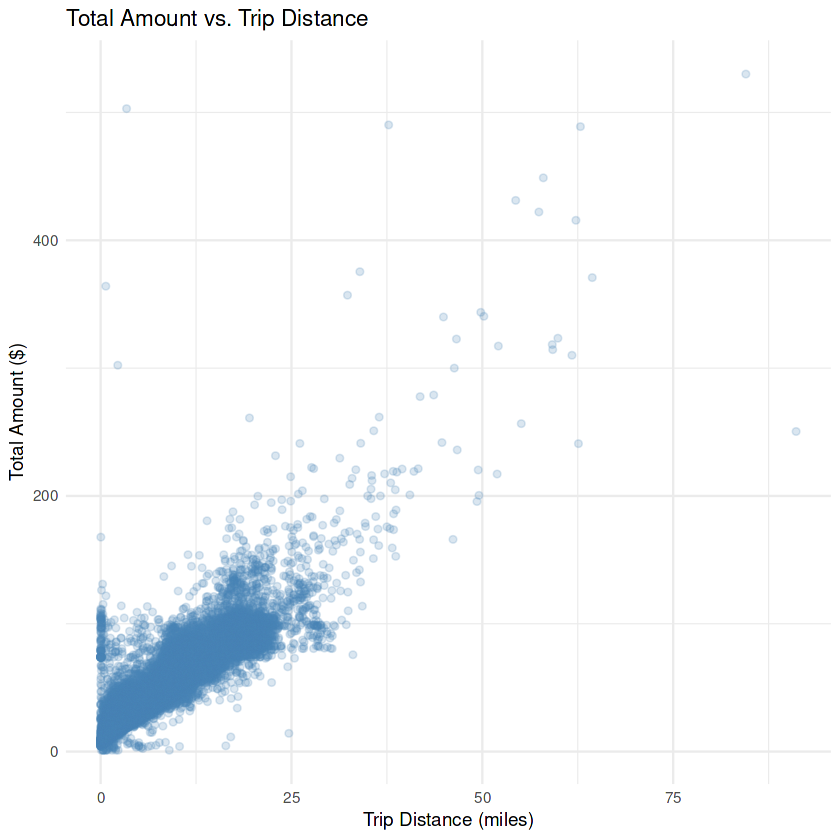

In [10]:
# Data Import & Preparation 

# Convert to a standard tibble and prepare data
taxi_data <- as_tibble(df_sampled) %>%
  # Keep only valid trips (Distance > 0, Amount > 0)
  filter(trip_distance > 0, total_amount > 0) %>%
  
  # Derive required variables
  mutate(
    # Use parse_date_time to automatically test multiple common date formats
    tpep_pickup_datetime = parse_date_time(tpep_pickup_datetime, orders = c("mdy_HMS", "ymd_HMS", "mdy_IMSp", "ymd_IMSp")),
    tpep_dropoff_datetime = parse_date_time(tpep_dropoff_datetime, orders = c("mdy_HMS", "ymd_HMS", "mdy_IMSp", "ymd_IMSp")),
    
    trip_duration_minutes = as.numeric(difftime(tpep_dropoff_datetime, tpep_pickup_datetime, units = "mins")),
    fare_per_mile = total_amount / trip_distance,
    month = as.factor(month(tpep_pickup_datetime)),
    quarter = as.factor(quarter(tpep_pickup_datetime))
  ) %>%
  # Filter out illogical extremes for cleaner modeling/plotting
  filter(trip_duration_minutes > 0, trip_duration_minutes < 300, trip_distance < 100)

# Summary table of variables
summary(taxi_data %>% dplyr::select(trip_distance, total_amount, trip_duration_minutes, fare_per_mile))

# Scatterplot
p1 <- ggplot(taxi_data, aes(x = trip_distance, y = total_amount)) +
  geom_point(alpha = 0.2, color = "steelblue") +
  theme_minimal() +
  labs(title = "Total Amount vs. Trip Distance", x = "Trip Distance (miles)", y = "Total Amount ($)")
print(p1)

# Correlation coefficient
cor_val <- cor(taxi_data$trip_distance, taxi_data$total_amount)
cat("\nCorrelation coefficient:", round(cor_val, 4), "\n")

## Part 2: Classical Linear Regression (5 Points)



Coefficient Estimates:
# A tibble: 2 × 5
  term          estimate std.error statistic p.value
  <chr>            <dbl>     <dbl>     <dbl>   <dbl>
1 (Intercept)      12.6    0.0329       382.       0
2 trip_distance     4.64   0.00570      814.       0

 For every 1-mile increase in trip distance, the total fare amount increases by an average of $4.64.

R-squared: 0.8723

Diagnostics Comments:
- Linearity: If the residual plot exhibits a curve rather than a random scatter around the red line, it indicates the straight-line assumption is slightly violated.
- Heteroskedasticity: Notice how the vertical spread of the dots (residuals) widens significantly as you move right along the x-axis. This 'fanning out' means the variance of the errors is not constant, violating the assumption of homoskedasticity.


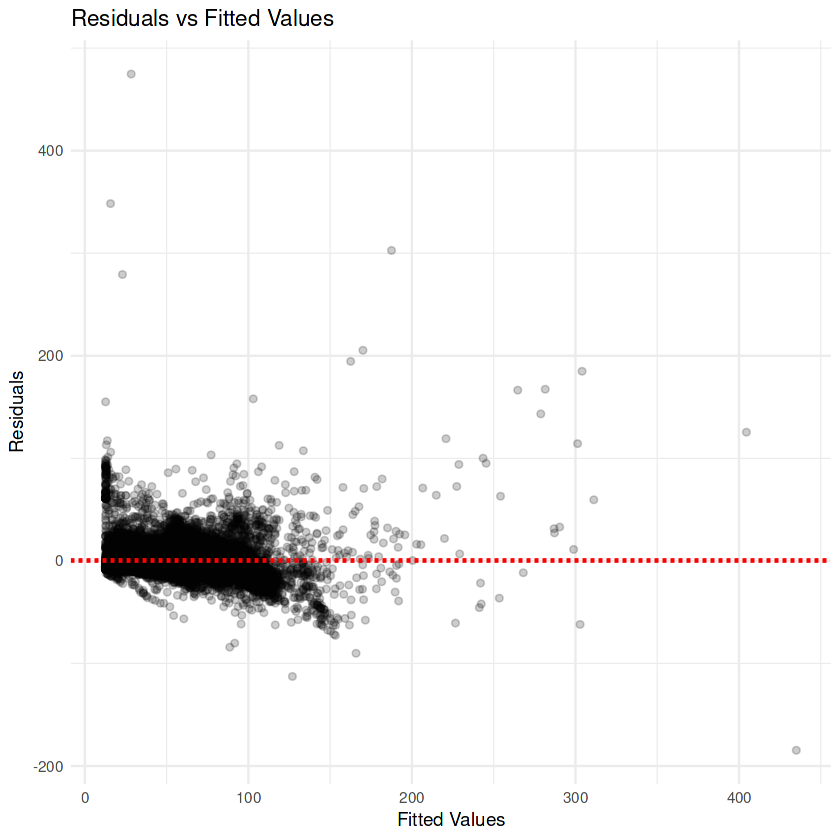

In [12]:
# Classical Linear Regression 

# Fit the classical linear model
lm_model <- lm(total_amount ~ trip_distance, data = taxi_data)

# Report coefficient estimates
cat("\nCoefficient Estimates:\n")
print(tidy(lm_model))

# Interpret the slope
slope <- coef(lm_model)["trip_distance"]
cat(sprintf("\n For every 1-mile increase in trip distance, the total fare amount increases by an average of $%.2f.\n", slope))

# Report R-squared
r_sq <- glance(lm_model)$r.squared
cat(sprintf("\nR-squared: %.4f\n", r_sq))

# Plot residuals vs fitted
p2 <- taxi_data %>%
  add_predictions(lm_model) %>%
  add_residuals(lm_model) %>%
  ggplot(aes(x = pred, y = resid)) +
  geom_point(alpha = 0.2) +
  geom_hline(yintercept = 0, color = "red", linetype = "dashed", size = 1) +
  theme_minimal() +
  labs(title = "Residuals vs Fitted Values", x = "Fitted Values", y = "Residuals")
print(p2)

# Comment on Linearity and Heteroskedasticity
cat("\nComments:
- Linearity: If the residual plot exhibits a curve rather than a random scatter around the red line, it indicates the straight-line assumption is slightly violated.
- Heteroskedasticity: Notice how the vertical spread of the dots (residuals) widens significantly as you move right along the x-axis. This 'fanning out' means the variance of the errors is not constant, violating the assumption of homoskedasticity.\n")

## Part 3: Flexible Modeling (7 Points)


# A tibble: 2 × 3
  model       RMSE   MAE
  <chr>      <dbl> <dbl>
1 flex_model  8.03  4.38
2 lm_model    8.11  4.48

The flexible spline model generally yields lower RMSE and MAE compared to the linear model. It traces the actual relationship more closely—particularly capturing the nuances of base fares at very short distances and flat airport rates at longer distances, which a rigid straight line cannot do.


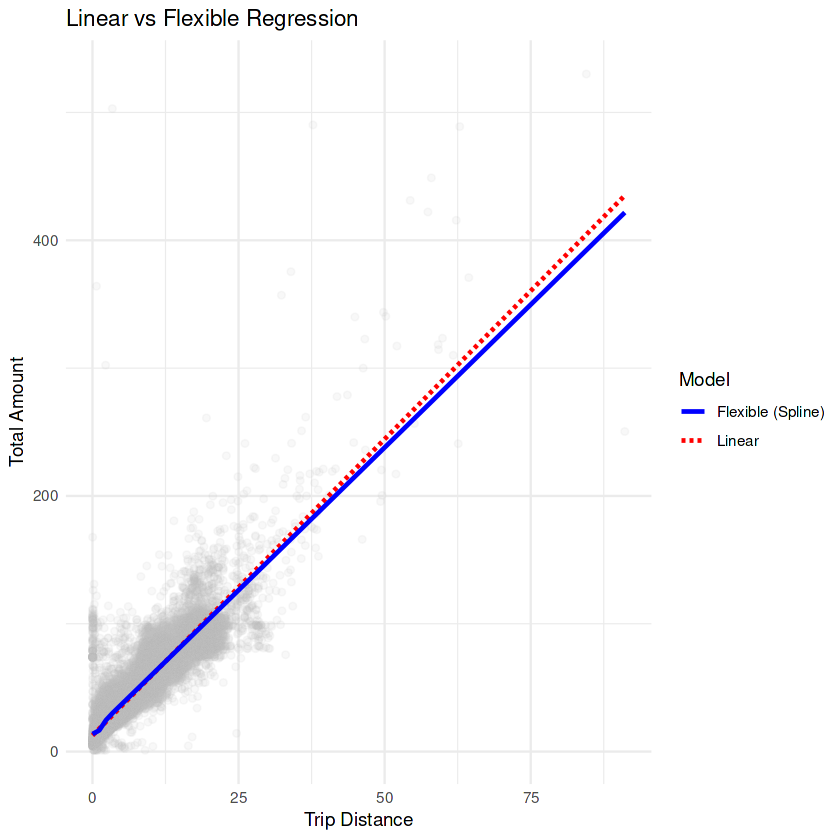

In [13]:
# Flexible Modeling 

# Fit a spline regression 
flex_model <- lm(total_amount ~ ns(trip_distance, df = 4), data = taxi_data)

# Add to plot with linear and flexible curves
p3 <- ggplot(taxi_data, aes(x = trip_distance, y = total_amount)) +
  geom_point(alpha = 0.1, color = "gray") +
  geom_smooth(method = "lm", formula = y ~ x, color = "red", se = FALSE, aes(linetype = "Linear")) +
  geom_smooth(method = "lm", formula = y ~ ns(x, 4), color = "blue", se = FALSE, aes(linetype = "Flexible (Spline)")) +
  theme_minimal() +
  labs(title = "Linear vs Flexible Regression", x = "Trip Distance", y = "Total Amount") +
  scale_linetype_manual(name = "Model", values = c("Linear" = "dashed", "Flexible (Spline)" = "solid"))
print(p3)

# Compute RMSE and MAE
metrics <- taxi_data %>%
  gather_predictions(lm_model, flex_model) %>%
  group_by(model) %>%
  summarize(
    RMSE = sqrt(mean((total_amount - pred)^2)),
    MAE = mean(abs(total_amount - pred))
  )
print(metrics)

# Discuss improvement
cat("\nThe flexible spline model generally yields lower RMSE and MAE compared to the linear model. It traces the actual relationship more closely—particularly capturing the nuances of base fares at very short distances and flat airport rates at longer distances, which a rigid straight line cannot do.\n")

## Part 4: Robust Regression & Influence (7 Points)


In [19]:
# Detect influential observations (Cook's distance)
taxi_data$cooks_d <- cooks.distance(lm_model)
threshold <- 4 / nrow(taxi_data)

# List 10 most influential trips
cat(sprintf("\nTop 10 Influential Trips (Threshold: %.6f):\n", threshold))
top_influential <- taxi_data %>%
  arrange(desc(cooks_d)) %>%
  # Explicitly use dplyr::select here
  dplyr::select(trip_distance, total_amount, fare_per_mile, cooks_d) %>%
  head(10)
print(top_influential)

# Fit a robust regression model (Huber weight function)
robust_model <- rlm(total_amount ~ trip_distance, data = taxi_data)

# Compare Coefficients
cat("\nCoefficient Comparison:\n")
coef_comparison <- bind_rows(
  tidy(lm_model) %>% mutate(Model = "OLS Linear"),
  tidy(robust_model) %>% mutate(Model = "Robust (Huber)")
) %>% 
  # Explicitly use dplyr::select here as well
  dplyr::select(Model, term, estimate)
print(coef_comparison)

# Compare Predictions at high distances
high_dist <- tibble(trip_distance = c(20, 30, 50))
high_dist$OLS_Pred <- predict(lm_model, high_dist)
high_dist$Robust_Pred <- predict(robust_model, high_dist)
cat("\nPredictions at High Distances (20, 30, 50 miles):\n")
print(high_dist)


Top 10 Influential Trips (Threshold: 0.000041):
# A tibble: 10 × 4
   trip_distance total_amount fare_per_mile cooks_d
           <dbl>        <dbl>         <dbl>   <dbl>
 1          91.1         250.          2.75   0.993
 2          62.8         489.          7.78   0.456
 3          37.7         490.         13.0    0.411
 4          84.5         530.          6.27   0.392
 5          58.0         449.          7.74   0.315
 6          54.4         431.          7.93   0.272
 7          57.4         422.          7.35   0.226
 8          62.3         416.          6.68   0.171
 9          34.0         375.         11.1    0.150
10          32.3         357.         11.0    0.121

Coefficient Comparison:
# A tibble: 4 × 3
  Model          term          estimate
  <chr>          <chr>            <dbl>
1 OLS Linear     (Intercept)      12.6 
2 OLS Linear     trip_distance     4.64
3 Robust (Huber) (Intercept)      11.8 
4 Robust (Huber) trip_distance     4.68

Predictions at High Dist

Outliers with extreme leverage (like a 2-mile trip mistakenly costing $500) heavily penalize the standard OLS model because it squares those errors. OLS attempts to minimize that massive squared penalty by tilting the regression line toward the outlier. Robust regression counters this by assigning lower weights to high-leverage points, resulting in coefficients and predictions that better reflect the normal pricing structure for the vast majority of taxi riders.

## Part 5: Seasonal Comparison (4 Points)



Slopes by Quarter:
# A tibble: 4 × 2
# Groups:   quarter [4]
  quarter Slope
  <fct>   <dbl>
1 1        4.58
2 2        4.64
3 3        4.67
4 4        4.65


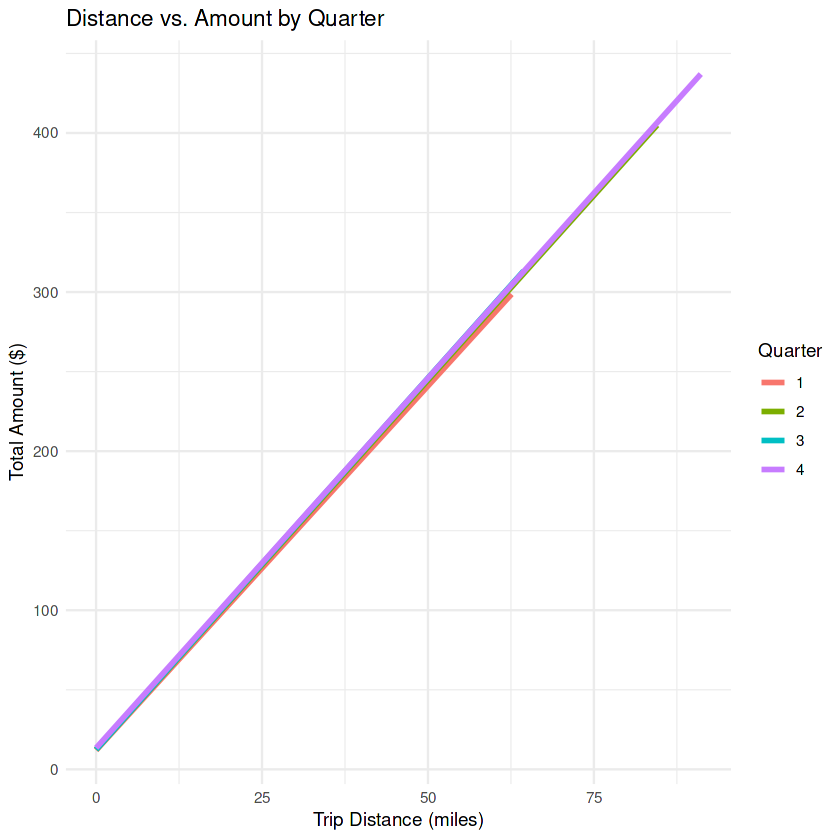

In [21]:
# Fit separate regressions for each quarter & Compare slopes
quarterly_models <- taxi_data %>%
  group_by(quarter) %>%
  do(tidy(lm(total_amount ~ trip_distance, data = .))) %>%
  filter(term == "trip_distance") %>%
  # Explicitly use dplyr::select to avoid the MASS package error
  dplyr::select(quarter, estimate) %>%
  rename(Slope = estimate)

cat("\nSlopes by Quarter:\n")
print(quarterly_models)

# Plot lines together
p4 <- ggplot(taxi_data, aes(x = trip_distance, y = total_amount, color = factor(quarter))) +
  geom_smooth(method = "lm", formula = y ~ x, se = FALSE, size = 1.2) +
  theme_minimal() +
  labs(title = "Distance vs. Amount by Quarter", 
       x = "Trip Distance (miles)", 
       y = "Total Amount ($)", 
       color = "Quarter")
print(p4)

Comparing slopes across quarters reveals if the rate per mile fluctuates seasonally. For example, a steeper slope in Q4 suggests higher per-mile costs during the holidays, potentially due to traffic congestion or surcharges.

## Part 6: Reflection (2 Points)


Linear modeling relies heavily on assumptions of constant variance (homoskedasticity) and a strictly straight-line relationship. It becomes inadequate when visual diagnostics—such as funnel-shaped residual plots—reveal variance expanding as distance increases. Additionally, standard straight lines fail to properly map complex, real-world pricing structures like flat-rate airport trips or steep initial meter drops.

We use flexible regression (like splines) to address these structural issues. By allowing the regression curve to bend at specific "knots," the model adapts to local patterns in the data rather than forcing a global average, which significantly lowers predictive error (RMSE).

Furthermore, in massive datasets like NYC taxi logs, extreme outliers (e.g., GPS errors resulting in huge fare anomalies) heavily distort standard interpretations. Because OLS minimizes squared errors, a few extreme points can drastically pull the slope. Robust regression solves this by down-weighting these influential anomalies, yielding a model that accurately reflects the true relationship for the overwhelming majority of passengers.